# Nowcasting for multiple states

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
import os
sns.set()

In [2]:
from nowcasting_functions import *

In [7]:
cwd = os.getcwd()

You can add states below, but plotting is set up for 12 subplots

In [130]:
states = ['AC', 'SP', 'PA', 'DF', 'RO', 'RR', 'CE', 'PE', 'RJ', 'SC', 'AM', 'Brazil']

### Load and prepare the data

In [111]:
# Load the data
data_new = pd.read_csv('data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
print("First date:", data_new.Date.values[0])
print("Last date:", data_new.Date.values[-1])
data_new

First date: 2019-12-31
Last date: 2021-02-07


,State,Date,Deaths,Release,Date_index,Release_index
0,SC,2019-12-31,1,2020-07-07,-1,0
1,PE,2020-01-02,1,2020-07-07,1,0
2,SP,2020-01-02,1,2020-07-07,1,0
3,AM,2020-01-03,1,2020-07-07,2,0
4,PR,2020-01-03,1,2020-07-07,2,0
...,...,...,...,...,...,...
191453,RO,2021-02-07,1,2021-02-08,403,216
191454,RS,2021-02-07,5,2021-02-08,403,216
191455,SC,2021-02-07,5,2021-02-08,403,216
191456,SE,2021-02-07,2,2021-02-08,403,216


In [112]:
data_new.Release.unique()

array(['2020-07-07', '2020-07-14', '2020-07-21', '2020-07-29',
       '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
       '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
       '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
       '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08'],
      dtype=object)

In [113]:
# Prepare the data for nowcast
data_new['Release_index'] = data_new.Release.astype('category').cat.codes
data_new = data_new[data_new['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
data_new = data_new[data_new['Release'] >= '2020-06-30'] # cut off early days as they are less relevant

In [114]:
# check if all states of interest are in the df
set(states[:-1]).issubset(list(data_new.State.unique()))

True

### Get the STAN model

In [6]:
model = pystan.StanModel(file=cwd+'/stan_models/4comp_longshort_SE.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1 NOW.


Model compiled


In [104]:
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        # need to merge!!!!!!
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

def do_nowcast_for_state(df, state, model):
    data = get_state_data(df, state)
    fit, results = fit_model(data, precompiled=False, modelname=model, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')
    return fit, results

In [115]:
get_state_data(data_new.copy(), 'Brazil')

,Date,Release,Date_index,Release_index,Deaths
0,2020-06-30,2020-07-07,181,0,722
1,2020-06-30,2020-07-14,181,1,933
2,2020-06-30,2020-07-21,181,2,1025
3,2020-06-30,2020-07-29,181,3,1091
4,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
3686,2021-02-03,2021-02-08,399,31,621
3687,2021-02-04,2021-02-08,400,31,486
3688,2021-02-05,2021-02-08,401,31,353
3689,2021-02-06,2021-02-08,402,31,225


### Do the nowcasting for each state

In [116]:
fits = {}
results = {}

for s in states:
    print('Nowcasting for ' + s)
    fit, result = do_nowcast_for_state(data_new.copy(), s, model)
    fits.update({s: fit})
    results.update({s: result})
    
print('All nowcasting completed')

Nowcasting for AC


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for SP


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PA


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for DF


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RO


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RR


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for CE


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for PE


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for RJ


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for SC


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for AM


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Nowcasting for Brazil


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


All nowcasting completed


In [117]:
results.keys()

dict_keys(['AC', 'SP', 'PA', 'DF', 'RO', 'RR', 'CE', 'PE', 'RJ', 'SC', 'AM', 'Brazil'])

In [118]:
# for each state plot the results
def plot_for_state(df, state, result_nowcast, show_x=True, show_y=True, show_legend=True):
    state_df = get_state_data(df, state)
    date_nowcast = state_df['Date'].values[-1]
    reported, _ = nowcasting_prep(state_df, date_nowcast, maxD=10)
    nowcasted = result_nowcast[state]
    
    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '95% CrI', color = 'orange')
    
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = '50% CrI', color = 'orange')

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color='blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    
    plt.title(state, fontsize=20)

### Plot the results

In [138]:
states_sorted = states.copy()
states_sorted.remove('Brazil')
states_sorted.sort()
states_sorted.append('Brazil')
states_sorted

['AC', 'AM', 'CE', 'DF', 'PA', 'PE', 'RJ', 'RO', 'RR', 'SC', 'SP', 'Brazil']

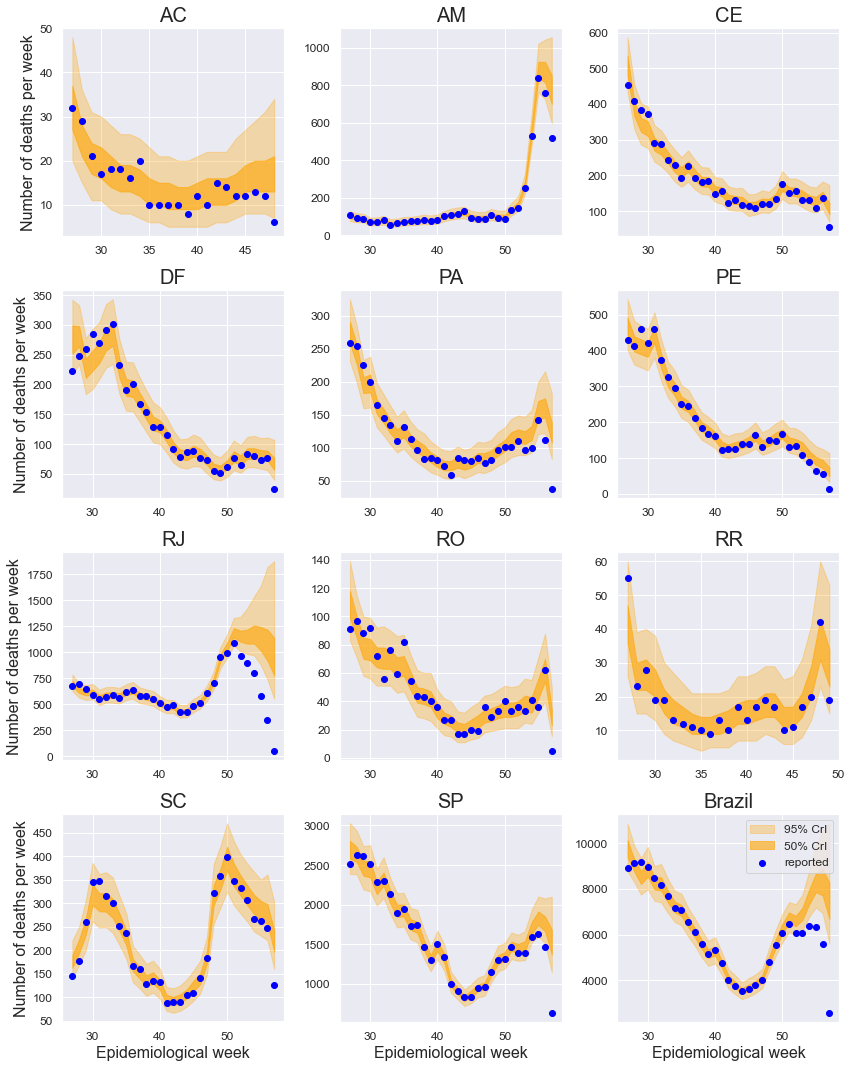

In [139]:
plt.figure(figsize=(12,15))

# for i in range(len(states)):
for i in range(len(states_sorted)):
    show_legend = False
    show_x = False
    show_y = False
    if i+1 == len(states):
        show_legend = True
    if i+1 in [1,4,7,10]:
        show_y = True
    if i+1 in [10, 11, 12]:
        show_x = True
    plt.subplot(4,3,i+1)
#     plot_for_state(data_new, states[i], results, show_x, show_y, show_legend)
    plot_for_state(data_new, states_sorted[i], results, show_x, show_y, show_legend)
plt.tight_layout()

plt.show()

## Alternative results with the NobBS model https://doi.org/10.1371/journal.pcbi.1007735

In [8]:
model_nobbs = pystan.StanModel(file=cwd+'/stan_models/nobbs.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9181fc5171bcd9e4177b4fcf30d5c22f NOW.


Model compiled


In [120]:
fits_nobbs = {}
results_nobbs = {}

for s in states:
    print('Nowcasting for ' + s)
    fit, result = do_nowcast_for_state(data_new, s, model_nobbs)
    fits_nobbs.update({s: fit})
    results_nobbs.update({s: result})
    
print('All nowcasting completed')

Nowcasting for AC
Nowcasting for SP
Nowcasting for PA
Nowcasting for DF
Nowcasting for RO
Nowcasting for RR


Nowcasting for CE
Nowcasting for PE
Nowcasting for RJ
Nowcasting for SC
Nowcasting for AM
Nowcasting for Brazil
All nowcasting completed


In [121]:
fits_nobbs.keys()

dict_keys(['AC', 'SP', 'PA', 'DF', 'RO', 'RR', 'CE', 'PE', 'RJ', 'SC', 'AM', 'Brazil'])

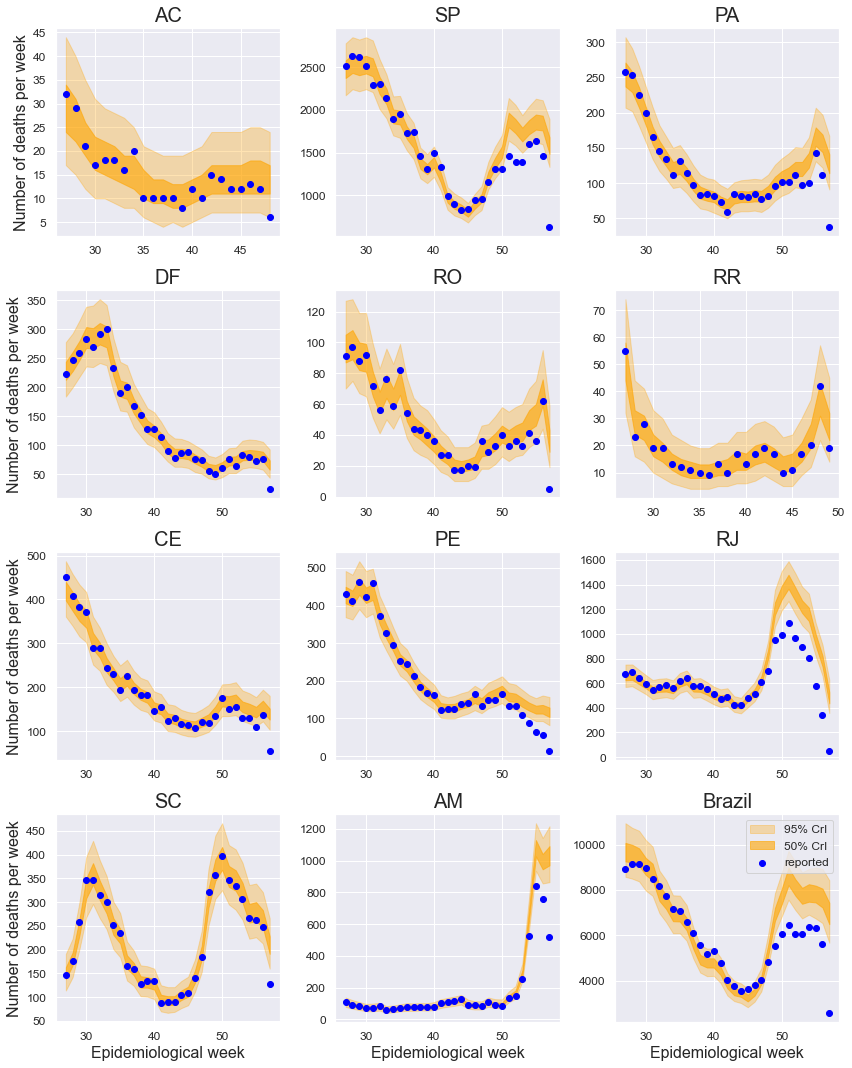

In [125]:
plt.figure(figsize=(12,15))

for i in range(len(states)):
    show_legend = False
    show_x = False
    show_y = False
    if i+1 == len(states):
        show_legend = True
    if i+1 in [1,4,7,10]:
        show_y = True
    if i+1 in [10, 11, 12]:
        show_x = True
    plt.subplot(4,3,i+1)
    plot_for_state(data_new, states[i], results_nobbs, show_x, show_y, show_legend)
plt.tight_layout()

plt.show()
